<a href="https://colab.research.google.com/github/Jude704/MastersThesis/blob/main/Fraud_Judith.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Basic Packages
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


#Pyod
try:
  import pyod
  import isotree
except:
  !pip install pyod
  !pip install isotree
finally:
  import pyod
  import isotree
  from pyod.models.abod import ABOD
  from pyod.models.iforest import IForest
  from pyod.models.ocsvm import OCSVM
  from pyod.models.lof import LOF
  from pyod.models.cblof import CBLOF
  from pyod.models.knn import KNN
  from pyod.utils.data import evaluate_print
  from pyod.models.hbos import HBOS

from sklearn.model_selection import StratifiedKFold 


from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import plot_precision_recall_curve

#oversampling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

#Sklearn Packages
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import sklearn.exceptions
from isotree import IsolationForest

#Warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

     |████████████████████████████████| 102kB 4.3MB/s 
  Created wheel for pyod: filename=pyod-0.8.7-cp37-none-any.whl size=115979 sha256=9fc254ffd822b4e99aebc67675cf83a06192b4521d37152f5273a7b2908e0d8b
  Stored in directory: /root/.cache/pip/wheels/b7/8a/c9/5fe3f32692ad445fe573cf5b953d7a0d55dc1f7c8e229ebda0
Successfully built pyod
     |████████████████████████████████| 153kB 11.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for isotree: filename=isotree-0.2.7-cp37-cp37m-linux_x86_64.whl size=5740048 sha256=48923d1baf54e07a69acdedaa4c8a89805a985002bdf1b946de1c8c1b26b7050
  Stored in directory: /root/.cache/pip/wheels/1c/0d/3b/0f86713e664973c91dad4bfec9cc8a183560c45a1ff0146f19
Successfully built isotree


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [2]:
#Functions 

#

def get_contamination_percentages(label_series, normal_value):
    return len(label_series[label_series != normal_value])/len(label_series)
    
def get_prediction(classifier, train_X, test_X, train_y, test_y, model_name =''):
    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)

    #Evaluate using Pyod built-in function
    print("On Training Data:")
    evaluate_print(model_name, train_y, clf.decision_scores_)
    print("\nOn Test Data:")
    evaluate_print(model_name, test_y, clf.decision_function(test_X))
    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, pred))
    #print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(test_y, pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, pred))
    print("\n", model_name, "f1-score", f1_score(test_y, pred))

  
    plt.figure()
    plt.subplot(2, 1, 1) 
    sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)
    

    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.subplot(2, 1, 2) 
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_prediction_iso(classifier, train_X, test_X, train_y, test_y, normal_value, model_name =''):
    clf = classifier.fit(train_X)
    pred = clf.predict(test_X)
    
    temp_pred = np.array(pred)
    temp_pred[temp_pred > 0.50] = 1
    temp_pred[temp_pred < 0.50] = 0

    print("\n", model_name, " Classification Report: \n" , classification_report(test_y, temp_pred))
    print("\n", model_name, " Confusion Matrix: \n" , confusion_matrix(test_y, temp_pred))
    print("\n", model_name, "Matthews Correlation Coefficient", matthews_corrcoef(test_y, temp_pred))
    print("\n", model_name, "f1-score", f1_score(test_y, temp_pred))

    plt.figure()
    plt.subplot(2, 1, 1) 
    sns.heatmap(data = confusion_matrix(test_y, pred),
                xticklabels = ['Predicted Normal','Predicted Anomaly'],
                yticklabels = ['Actual Normal','Actual Anomaly'],
                linewidths=.2,
               cmap = "YlGnBu",
                linecolor="Darkblue",
               fmt = 'd',
               annot = True)
    plt.title('Confusion Matrix', fontsize = 14)
    

    plt.figure()
    model_decision = clf.decision_function(test_X)
    fpr, tpr, threshold = roc_curve(test_y, model_decision)
    roc_auc = auc(fpr, tpr)
    plt.subplot(2, 1, 2) 
    plt.plot(fpr, tpr, color='orange', label='AUC = %0.2f'% roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    

In [10]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
data.shape

(284807, 31)

In [ ]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [13]:
from sklearn.preprocessing import RobustScaler
#robustscaler is more robust when there are outliers

data['amount'] = RobustScaler().fit_transform(data['Amount'].values.reshape(-1, 1), data['Class'])
data['time'] = RobustScaler().fit_transform(data['Time'].values.reshape(-1,1), data['Class'])
data = data.drop(['Amount'],axis=1)
data = data.drop(['Time'],axis=1)
data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,amount,time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.296653,1.034951
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,0.038986,1.034963
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,0.641096,1.034975
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.167680,1.034975


In [14]:
data = data.dropna()

### Visualization

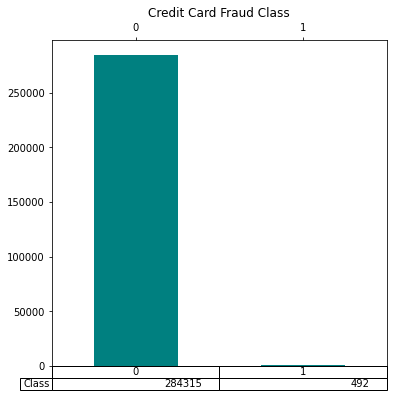

In [ ]:
def bar_graph(feature):
    data["Class"].value_counts().plot(kind="bar",
                                          layout =True,
                                          use_index = True,
                                          title = 'Credit Card Fraud Class',
                                          grid = False,
                                          color ='teal',
                                          table = True).xaxis.tick_top()

plt.figure(figsize=(6,6))
bar_graph('Class') 

### Clustering of anomalies

In [ ]:
class_1 = data[data['Class'] == 1]

In [ ]:
class_1 = class_1.drop(['Time'], axis=1)

In [ ]:
class_1.shape

(492, 30)

KMeans

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters= 4, random_state= 42).fit(class_1)

In [ ]:
labels = kmeans.fit_predict(class_1)
centroids = kmeans.cluster_centers_

In [ ]:
class_1['Cluster'] = labels

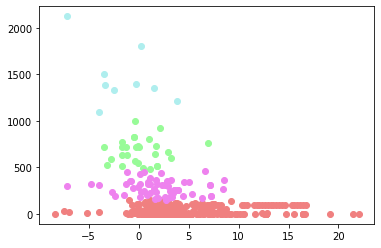

In [ ]:
df1 = class_1[class_1.Cluster == 0]
df2 = class_1[class_1.Cluster == 1]
df3 = class_1[class_1.Cluster == 2]
df4 = class_1[class_1.Cluster == 3]
#df5 = class_1[class_1.Cluster == 4]
plt.scatter(df1.iloc[:, 1], df1.Amount, color='lightcoral')
plt.scatter(df2.iloc[:, 1], df2.Amount, color='palegreen')
plt.scatter(df3.iloc[:, 1], df3.Amount, color='paleturquoise')
plt.scatter(df4.iloc[:, 1], df4.Amount, color= 'violet')
#plt.scatter(df5.iloc[:, 1], df5.Amount, color= 'pink')

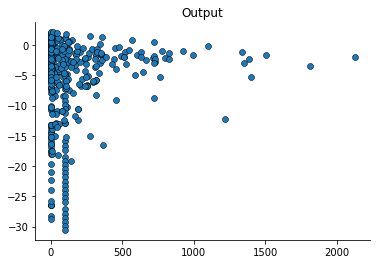

In [ ]:
plt.scatter(class_1['Amount'], class_1.iloc[:, 1], linewidth=0.5, edgecolor='black')
sns.despine()
plt.title("Output")
pass

DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=1.10, min_samples=2).fit(class_1)
class_1["Cluster"] = clustering.fit_predict(class_1)
class_1["Cluster"].value_counts()

-1     446
 4       6
 17      4
 9       2
 0       2
 2       2
 3       2
 5       2
 6       2
 7       2
 8       2
 1       2
 19      2
 11      2
 12      2
 13      2
 14      2
 15      2
 16      2
 18      2
 10      2
Name: Cluster, dtype: int64

In [ ]:
class_1['Cluster'].describe

<bound method NDFrame.describe of 541      -1
623      -1
4920     -1
6108     -1
6329     -1
         ..
279863   -1
280143   -1
280149   -1
281144   -1
281674   -1
Name: Cluster, Length: 492, dtype: int64>

In [ ]:
colors = {-1: 'lightcoral', 0: 'palegreen', 1: 'paleturquoise', 2: 'violet'}
fig, ax = plt.subplots(figsize=(8,8))
grouped = class_1.groupby('Cluster')
for key, group in grouped:
  group.plot(ax=ax, kind='scatter', x=class_1.iloc[:, 1], y= class_1.Amount, color= colors[key])
plt.show()

### Dimensionality Reduction

In [ ]:
!pip install MulticoreTSNE

In [ ]:
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D

from MulticoreTSNE import MulticoreTSNE as TSNE

In [ ]:
def gen_dataset(samples):
    '''
    Generates dataset with all fraud transactions and "samples" part of non_fraud transactions
    '''
    # Sub-sampling dataset
    fraud = df[df['Class'] == 1]
    non_fraud = df[df['Class'] == 0].sample(samples, random_state = 1)
    df_scaled = pd.concat([fraud, non_fraud])
    df_scaled = shuffle(df_scaled, random_state = 1)

    Y = df_scaled['Class']

    df_scaled = df_scaled.drop('Class', axis = 1)

    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns = df_scaled.columns)
    return (df_scaled, Y)


In [ ]:
def plots(df_2d, df3d, t = False):
    '''
    Creates 2d and 3d plots
    '''
    fig = plt.figure(figsize = (20, 8))
    ax1 = fig.add_subplot(121)
    if t:
        sns.scatterplot(x = 'PC1', y = 'PC2', data = df_2d, hue = 'Class').set_title(f'TSNE with 2 components')
    else:
        sns.scatterplot(x = 'PC1', y = 'PC2', data = df_2d, hue = 'Class').set_title(f'PCA with 2 components\nexpl. variance: {variance_2d}%')

    ax2 = fig.add_subplot(122, projection = '3d')
    f = df3d[df3d['Class'] == 1]
    nf = df3d[df3d['Class'] == 0]
    ax2.scatter(nf['PC1'], nf['PC2'], nf['PC3'], marker = 'o')
    ax2.scatter(f['PC1'], f['PC2'], f['PC3'], marker = 'x')
    ax2.view_init(30, 240)
    if t:
        plt.title(('TSNE with 3 components'))
    else:
        plt.title((f'PCA with 3 components\nexpl. variance: {variance_3d}%'))
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('PC3')
    plt.show()

In [ ]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df_pca, Y = gen_dataset(50000)

PCA

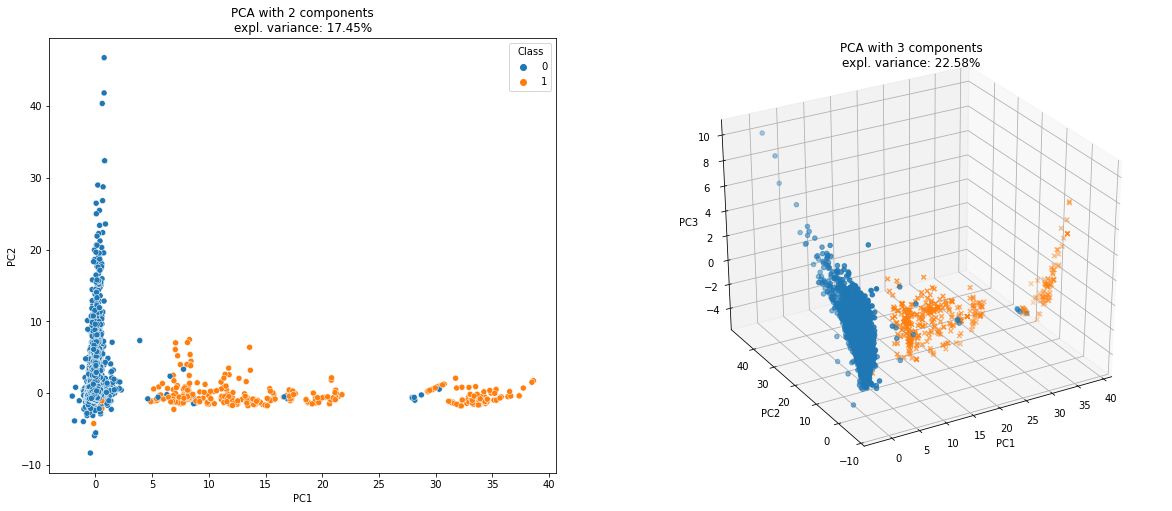

In [ ]:
# PCA with 2 components
pca_2d = PCA(n_components = 2, random_state = 1)
pca_df_2d = pca_2d.fit_transform(df_pca)
variance_2d = round(sum(pca_2d.explained_variance_ratio_) * 100, 2)
pca_df_2d = pd.DataFrame(pca_df_2d, columns = ['PC1', 'PC2'])
pca_df_2d['Class'] = Y.values

# PCA with 3 components
pca_3d = PCA(n_components = 3, random_state = 1)
pca_df_3d = pca_3d.fit_transform(df_pca)
variance_3d = round(sum(pca_3d.explained_variance_ratio_) * 100, 2)
pca_df_3d = pd.DataFrame(pca_df_3d, columns = ['PC1', 'PC2', 'PC3'])
pca_df_3d['Class'] = Y.values

plots(pca_df_2d, pca_df_3d)

TSNE

In [ ]:
df_tsne, Y = gen_dataset(15000)

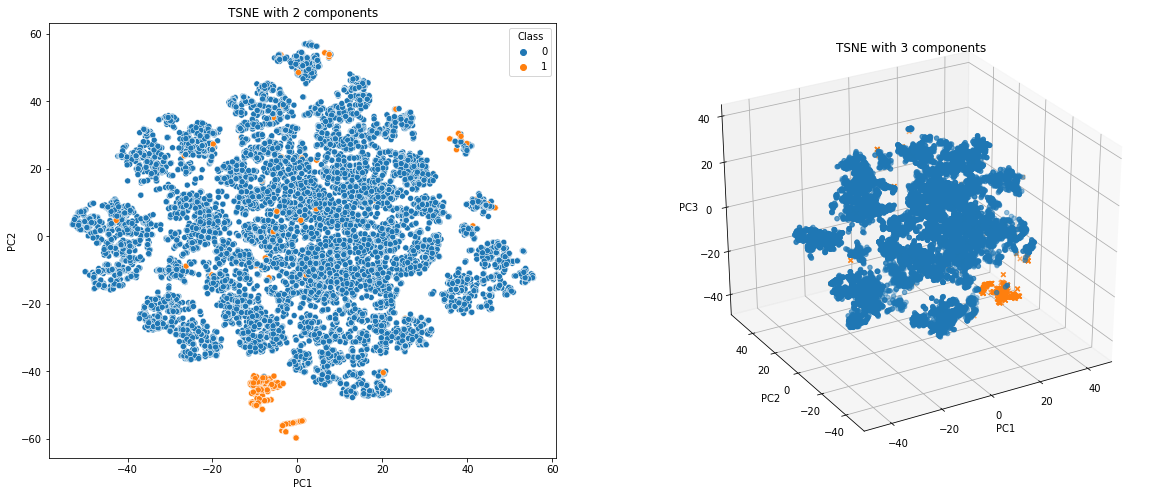

In [ ]:
tsne_2d = TSNE(n_components = 2, 
            perplexity = 30, 
            early_exaggeration=12.0,
            learning_rate=200.0,
            n_iter=1000,
            random_state = 1, 
            n_jobs = -1)
tsne_df_2d = tsne_2d.fit_transform(df_tsne)

tsne_df_2d = pd.DataFrame(tsne_df_2d, columns = ['PC1', 'PC2'])
tsne_df_2d['Class'] = Y.values

tsne_3d = TSNE(n_components = 3, 
            perplexity = 30, 
            early_exaggeration=12.0,
            learning_rate=200.0,
            n_iter=1000,
            random_state = 1, 
            n_jobs = -1)
tsne_df_3d = tsne_3d.fit_transform(df_tsne)

tsne_df_3d = pd.DataFrame(tsne_df_3d, columns = ['PC1', 'PC2', 'PC3'])
tsne_df_3d['Class'] = Y.values

plots(tsne_df_2d, tsne_df_3d, t = True)

### Split data

In [15]:
def time_split_train_test(full_dataframe,):
  train_set = full_dataframe.truncate(before= 1, after= 213605)
  train_X = train_set.drop('Class', axis = 1)
  train_y = train_set['Class']
  test_set = full_dataframe.truncate(before=213606)
  test_X = test_set.drop('Class', axis = 1)
  test_y = test_set['Class']
  return train_X, test_X, train_y, test_y

In [16]:
train_X, test_X, train_y, test_y = time_split_train_test(data)

In [17]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.0018632522646941786
Percentage Test Set Contamination:      0.0013202061768795381


### Machine Learning: after tuning, no over/undersampling

DiFF

In [19]:
from DiFF_RF import DiFF_TreeEnsemble

SyntaxError: ignored

In [ ]:
get_prediction(DiFF_TreeEnsemble(sample_size = 100, n_trees= 100), train_X, test_X, train_y, test_y, 'DiFF')

ABOD

On Training Data:
HBOS ROC:0.9151, precision @ rank n:0.093

On Test Data:
HBOS ROC:0.9312, precision @ rank n:0.0319

 HBOS  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71107
           1       0.07      0.15      0.10        94

    accuracy                           1.00     71201
   macro avg       0.54      0.57      0.55     71201
weighted avg       1.00      1.00      1.00     71201


 HBOS Matthews Correlation Coefficient 0.10171120368313488

 HBOS f1-score 0.09688581314878891


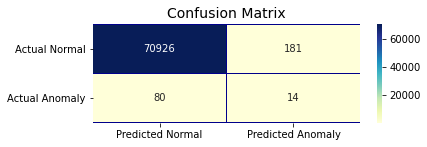

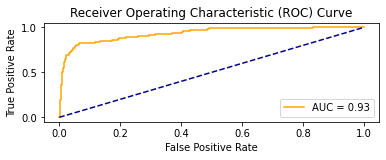

In [18]:
get_prediction(ABOD(contamination= 0.0018, n_neighbors= 10, method= 'fast'), train_X, test_X, train_y, test_y, 'ABOD')

HBOS

On Training Data:
HBOS ROC:0.9538, precision @ rank n:0.3442

On Test Data:
HBOS ROC:0.9401, precision @ rank n:0.0213

 HBOS  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71107
           1       0.04      0.04      0.04        94

    accuracy                           1.00     71201
   macro avg       0.52      0.52      0.52     71201
weighted avg       1.00      1.00      1.00     71201


 HBOS Matthews Correlation Coefficient 0.039324020210496954

 HBOS f1-score 0.04060913705583756


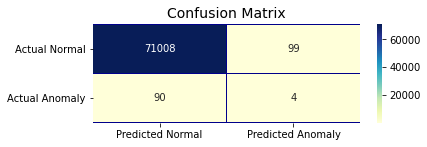

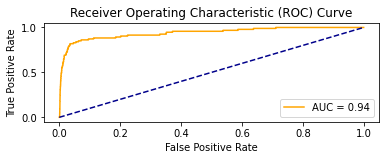

In [20]:
get_prediction(HBOS(n_bins= 20, alpha= 0.1, tol=0.5, contamination= 0.01), train_X, test_X, train_y, test_y, 'HBOS')

Isolation Forest

On Training Data:
IForest ROC:0.9476, precision @ rank n:0.3174

On Test Data:
IForest ROC:0.9301, precision @ rank n:0.0106

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71107
           1       0.01      0.01      0.01        94

    accuracy                           1.00     71201
   macro avg       0.50      0.50      0.50     71201
weighted avg       1.00      1.00      1.00     71201


 IForest Matthews Correlation Coefficient 0.008906741351718352

 IForest f1-score 0.010256410256410256


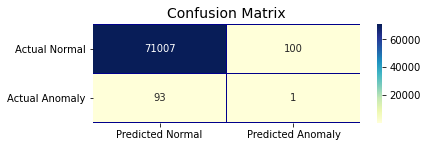

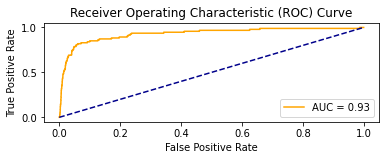

In [21]:
get_prediction(IForest(n_estimators = 100, max_samples=128, contamination= 0.01), train_X, test_X, train_y, test_y, 'IForest')

OCSVM

In [22]:
get_prediction(OCSVM(gamma = 0.0001, contamination= 0.0018, kernel = 'rbf'), train_X, test_X, train_y, test_y, 'OCSVM')

KeyboardInterrupt: ignored

LOF

In [ ]:
get_prediction(LOF(n_neighbors=500, contamination= 0.0017), train_X, test_X, train_y, test_y, 'LOF')

In [ ]:
get_prediction(CBLOF(n_clusters= 15, contamination= 0.0017, alpha=0.8, beta= 15), train_X, test_X, train_y, test_y, 'CBLOF')

In [ ]:
get_prediction(KNN(contamination= 0.0017, n_neighbors= 500, method= 'median'), train_X, test_X, train_y, test_y, 'KNN')

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), train_X, test_X, train_y, test_y, 'IForest')

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), train_X, test_X, train_y, test_y, 'SciForest')

### Machine Learning oversampled with smote

In [ ]:
#Oversampling with SMOTE
train_X_resampled, train_y_resampled= SMOTE(ratio = 'minority', random_state= 42).fit_sample(train_X, train_y)

In [ ]:
train_X_resampled.shape

(79862, 30)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y_resampled, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.5
Percentage Test Set Contamination:      0.002


HBOS

On Training Data:
HBOS ROC:0.8941, precision @ rank n:0.8103

On Test Data:
HBOS ROC:0.9088, precision @ rank n:0.2

 HBOS  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       0.00      0.00      0.00        20

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000


 HBOS Matthews Correlation Coefficient -0.0007754887617854406

 HBOS f1-score 0.0


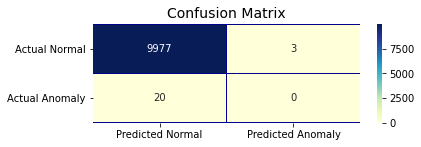

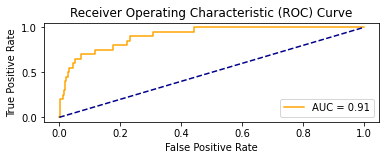

In [ ]:
get_prediction(HBOS(n_bins= 20, alpha= 0.1, tol=0.5, contamination= 0.0017), train_X_resampled, test_X, train_y_resampled, test_y, 'HBOS')

Isolation Forest

On Training Data:
IForest ROC:0.8445, precision @ rank n:0.7579

On Test Data:
IForest ROC:0.8614, precision @ rank n:0.05

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       0.00      0.00      0.00        20

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000


 IForest Matthews Correlation Coefficient 0.0

 IForest f1-score 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning:

invalid value encountered in double_scalars



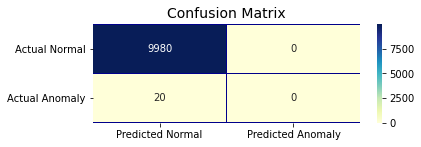

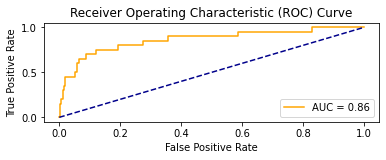

In [ ]:
get_prediction(IForest(n_estimators = 50, max_samples='auto', contamination= 0.0017), train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

OCSVM

OCSVM ROC:0.7716, precision @ rank n:0.1

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      9980
           1       0.03      0.10      0.05        20

    accuracy                           0.99     10000
   macro avg       0.51      0.55      0.52     10000
weighted avg       1.00      0.99      0.99     10000


 OCSVM Matthews Correlation Coefficient 0.05208596610851345

 OCSVM f1-score 0.04705882352941177


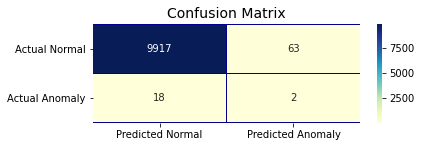

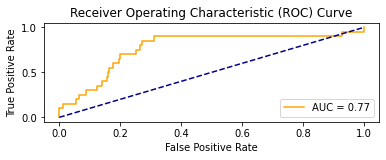

In [ ]:
get_prediction(OCSVM(gamma = 0.001, contamination= 0.0018, kernel = 'rbf'), train_X_resampled, test_X, train_y_resampled, test_y, 'OCSVM')

LOF

On Training Data:
LOF ROC:0.4956, precision @ rank n:0.493

On Test Data:
LOF ROC:0.4311, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       0.00      0.00      0.00        20

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000


 LOF Matthews Correlation Coefficient -0.0017920801621980232

 LOF f1-score 0.0


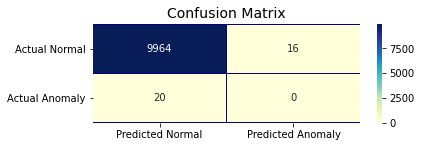

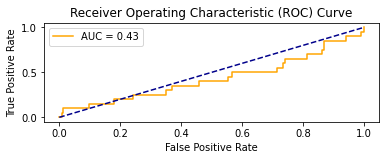

In [ ]:
get_prediction(LOF(n_neighbors=100, contamination= 0.0017), train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

On Training Data:
CBLOF ROC:0.3397, precision @ rank n:0.3862

On Test Data:
CBLOF ROC:0.5602, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       0.00      0.00      0.00        20

    accuracy                           0.99     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      0.99      1.00     10000


 CBLOF Matthews Correlation Coefficient -0.002614741406223922

 CBLOF f1-score 0.0


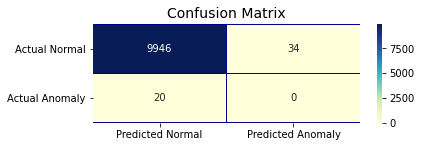

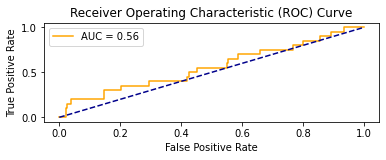

In [ ]:
get_prediction(CBLOF(n_clusters= 15, contamination= 0.0017, alpha=0.8, beta= 15), train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

On Training Data:
KNN ROC:0.2649, precision @ rank n:0.3132

On Test Data:
KNN ROC:0.5091, precision @ rank n:0.1

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       0.06      0.10      0.08        20

    accuracy                           1.00     10000
   macro avg       0.53      0.55      0.54     10000
weighted avg       1.00      1.00      1.00     10000


 KNN Matthews Correlation Coefficient 0.0767266224412169

 KNN f1-score 0.07692307692307693


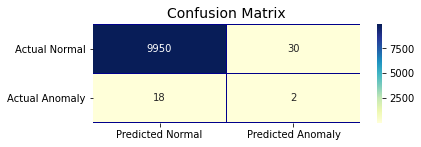

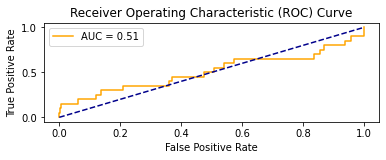

In [ ]:
get_prediction(KNN(contamination= 0.0018, n_neighbors= 500, method= 'median'), train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')


   Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      9980
           1       0.03      0.20      0.06        20

    accuracy                           0.99     10000
   macro avg       0.52      0.59      0.53     10000
weighted avg       1.00      0.99      0.99     10000


   Confusion Matrix: 
 [[9866  114]
 [  16    4]]

  Matthews Correlation Coefficient 0.07801999494723086

  f1-score 0.05797101449275363


ValueError: ignored

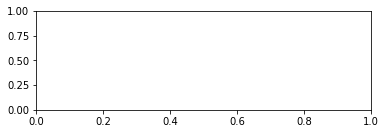

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')


   Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       0.00      0.00      0.00        20

    accuracy                           0.99     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      0.99      1.00     10000


   Confusion Matrix: 
 [[9946   34]
 [  20    0]]

  Matthews Correlation Coefficient -0.002614741406223922

  f1-score 0.0


ValueError: ignored

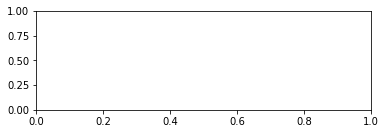

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')

### Machine Learning with random undersampling


In [ ]:
#Undersampling
train_X_resampled, train_y_resampled= RandomUnderSampler(ratio = 'majority', random_state= 42).fit_sample(train_X, train_y)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y_resampled, 0))
print("Percentage Test Set Contamination: ".ljust(39), get_contamination_percentages(test_y, 0))

Percentage Training Set Contamination:  0.5
Percentage Test Set Contamination:      0.002


HBOS

On Training Data:
HBOS ROC:0.9107, precision @ rank n:0.8261

On Test Data:
HBOS ROC:0.8863, precision @ rank n:0.2

 HBOS  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       0.00      0.00      0.00        20

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000


 HBOS Matthews Correlation Coefficient -0.0004476838657887675

 HBOS f1-score 0.0


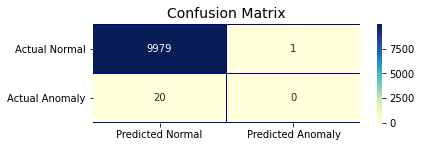

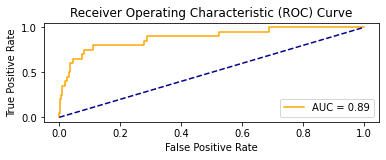

In [ ]:
get_prediction(HBOS(n_bins= 20, alpha= 0.1, tol=0.5, contamination= 0.0017), train_X_resampled, test_X, train_y_resampled, test_y, 'HBOS')

Isolation Forest

On Training Data:
IForest ROC:0.8616, precision @ rank n:0.8116

On Test Data:
IForest ROC:0.8106, precision @ rank n:0.15

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       0.00      0.00      0.00        20

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000


 IForest Matthews Correlation Coefficient 0.0

 IForest f1-score 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning:

invalid value encountered in double_scalars



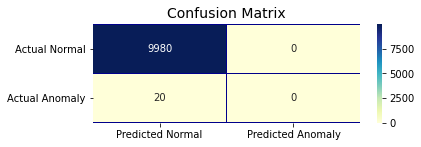

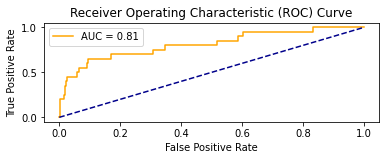

In [ ]:
get_prediction(IForest(n_estimators = 150, max_samples='auto', contamination= 0.0018), train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

OCSVM

OCSVM ROC:0.7716, precision @ rank n:0.1

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      9980
           1       0.03      0.10      0.05        20

    accuracy                           0.99     10000
   macro avg       0.51      0.55      0.52     10000
weighted avg       1.00      0.99      0.99     10000


 OCSVM Matthews Correlation Coefficient 0.05208596610851345

 OCSVM f1-score 0.04705882352941177


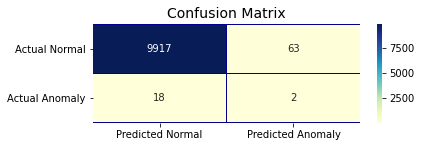

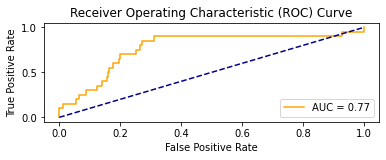

In [ ]:
get_prediction(OCSVM(gamma = 0.001, contamination= 0.0018, kernel = 'rbf'), train_X_resampled, test_X, train_y_resampled, test_y, 'OCSVM')

LOF

On Training Data:
LOF ROC:0.507, precision @ rank n:0.5072

On Test Data:
LOF ROC:0.4943, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      9980
           1       0.00      0.00      0.00        20

    accuracy                           0.98     10000
   macro avg       0.50      0.49      0.50     10000
weighted avg       1.00      0.98      0.99     10000


 LOF Matthews Correlation Coefficient -0.005780459878944238

 LOF f1-score 0.0


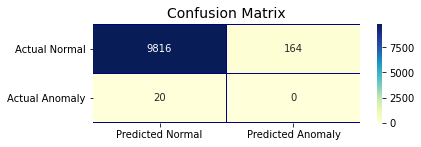

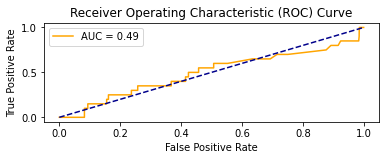

In [ ]:
get_prediction(LOF(n_neighbors=100, contamination= 0.0018), train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

On Training Data:
CBLOF ROC:0.5436, precision @ rank n:0.5507

On Test Data:
CBLOF ROC:0.6141, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      9980
           1       0.01      0.15      0.02        20

    accuracy                           0.97     10000
   macro avg       0.50      0.56      0.50     10000
weighted avg       1.00      0.97      0.98     10000


 CBLOF Matthews Correlation Coefficient 0.03118514815346396

 CBLOF f1-score 0.018518518518518517


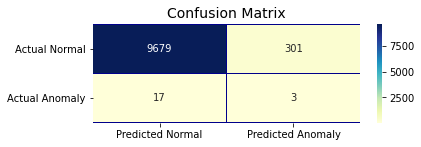

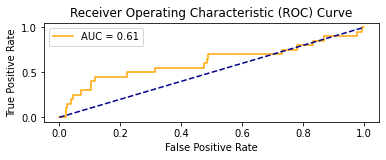

In [ ]:
get_prediction(CBLOF(n_clusters= 15, contamination= 0.0017, alpha=0.8, beta= 15), train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

On Training Data:
KNN ROC:0.4559, precision @ rank n:0.4559

On Test Data:
KNN ROC:0.4766, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      9980
           1       0.01      0.15      0.02        20

    accuracy                           0.97     10000
   macro avg       0.50      0.56      0.50     10000
weighted avg       1.00      0.97      0.98     10000


 KNN Matthews Correlation Coefficient 0.03285345029914408

 KNN f1-score 0.019801980198019806


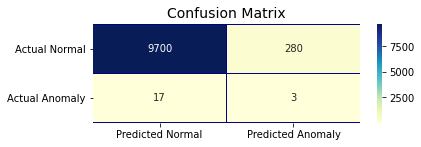

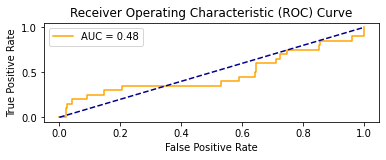

In [ ]:
get_prediction(KNN(contamination= 0.0017, n_neighbors= 5, method= 'median'), train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')


   Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      9980
           1       0.03      0.20      0.06        20

    accuracy                           0.99     10000
   macro avg       0.52      0.59      0.53     10000
weighted avg       1.00      0.99      0.99     10000


   Confusion Matrix: 
 [[9866  114]
 [  16    4]]

  Matthews Correlation Coefficient 0.07801999494723086

  f1-score 0.05797101449275363


ValueError: ignored

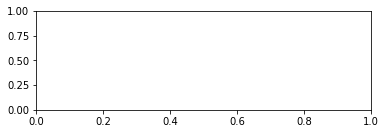

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

/usr/local/lib/python3.7/dist-packages/isotree/__init__.py:1253: UserWarning:

Input data has fewer rows than sample_size, will decrease sample_size.




   Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       0.00      0.00      0.00        20

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000


   Confusion Matrix: 
 [[9954   26]
 [  20    0]]

  Matthews Correlation Coefficient -0.0022856078513458326

  f1-score 0.0


ValueError: ignored

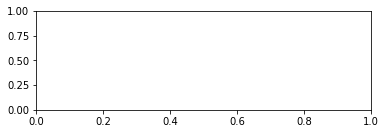

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')

### Subsampling to contamination rate 0.01

In [ ]:
train_y.value_counts()

0    213207
1       398
Name: Class, dtype: int64

In [ ]:
#3980 normal cases needed
#subsample train_X until it has only 3980 cases
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#Undersampling
train_X_resampled, train_y_resampled= RandomUnderSampler(0.0186, random_state= 42).fit_sample(train_X, train_y)

In [ ]:
print("Percentage Training Set Contamination: ".ljust(39), get_contamination_percentages(train_y_resampled, 0))

Percentage Training Set Contamination:  0.018261069052534985


HBOS

On Training Data:
HBOS ROC:0.9508, precision @ rank n:0.6005

On Test Data:
HBOS ROC:0.9401, precision @ rank n:0.0213

 HBOS  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71107
           1       0.00      0.00      0.00        94

    accuracy                           1.00     71201
   macro avg       0.50      0.50      0.50     71201
weighted avg       1.00      1.00      1.00     71201


 HBOS Matthews Correlation Coefficient -0.0007081560075746401

 HBOS f1-score 0.0


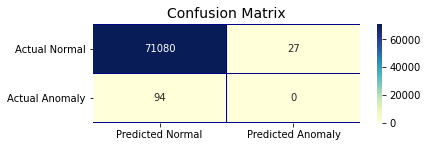

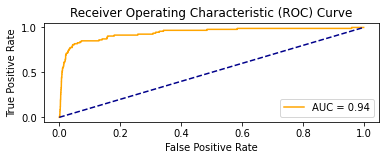

In [ ]:
get_prediction(HBOS(n_bins= 20, alpha= 0.1, tol=0.5, contamination= 0.0018), train_X_resampled, test_X, train_y_resampled, test_y, 'HBOS')

Isolation Forest

On Training Data:
IForest ROC:0.9459, precision @ rank n:0.6106

On Test Data:
IForest ROC:0.9368, precision @ rank n:0.0106

 IForest  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     71107
           1       0.00      0.00      0.00        94

    accuracy                           1.00     71201
   macro avg       0.50      0.50      0.50     71201
weighted avg       1.00      1.00      1.00     71201


 IForest Matthews Correlation Coefficient -0.0002725253444418754

 IForest f1-score 0.0


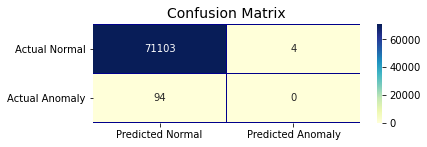

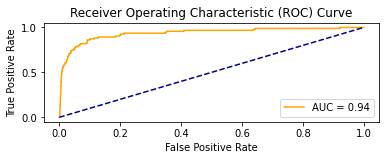

In [ ]:
get_prediction(IForest(n_estimators = 100, max_samples=128, contamination= 0.0017), train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

OCSVM

On Training Data:
OCSVM ROC:0.8337, precision @ rank n:0.0704

On Test Data:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



OCSVM ROC:0.4995, precision @ rank n:0.0

 OCSVM  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.00      0.01     71107
           1       0.00      1.00      0.00        94

    accuracy                           0.00     71201
   macro avg       0.50      0.50      0.00     71201
weighted avg       1.00      0.00      0.01     71201


 OCSVM Matthews Correlation Coefficient 0.002083312530948365

 OCSVM f1-score 0.0026455771016858517


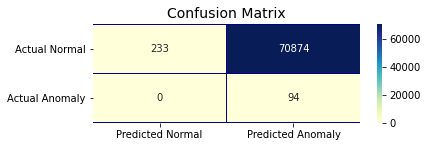

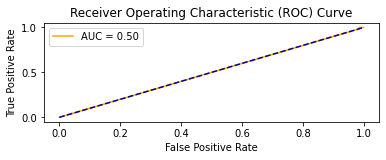

In [ ]:
get_prediction(OCSVM(gamma = 0.0001, contamination= 0.0018, kernel = 'rbf'), train_X_resampled, test_X, train_y_resampled, test_y, 'OCSVM')

LOF

On Training Data:
LOF ROC:0.6017, precision @ rank n:0.0176

On Test Data:
LOF ROC:0.4404, precision @ rank n:0.0

 LOF  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.00      0.01     71107
           1       0.00      1.00      0.00        94

    accuracy                           0.00     71201
   macro avg       0.50      0.50      0.00     71201
weighted avg       1.00      0.00      0.01     71201


 LOF Matthews Correlation Coefficient 0.0018807095718789567

 LOF f1-score 0.002643977216792068


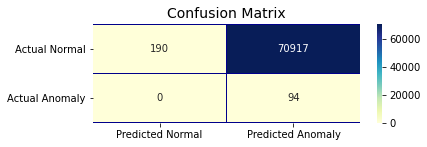

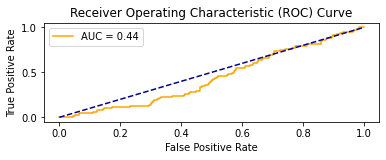

In [ ]:
get_prediction(LOF(n_neighbors=500, contamination= 0.0017), train_X_resampled, test_X, train_y_resampled, test_y, 'LOF')

On Training Data:
CBLOF ROC:0.5864, precision @ rank n:0.005

On Test Data:
CBLOF ROC:0.4404, precision @ rank n:0.0

 CBLOF  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     71107
           1       0.00      0.00      0.00        94

    accuracy                           0.96     71201
   macro avg       0.50      0.48      0.49     71201
weighted avg       1.00      0.96      0.98     71201


 CBLOF Matthews Correlation Coefficient -0.0070258640442613565

 CBLOF f1-score 0.0


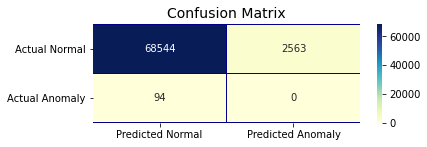

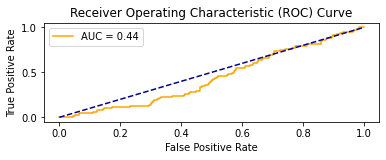

In [ ]:
get_prediction(CBLOF(n_clusters= 15, contamination= 0.0017, alpha=0.8, beta= 15), train_X_resampled, test_X, train_y_resampled, test_y, 'CBLOF')

On Training Data:
KNN ROC:0.6175, precision @ rank n:0.0779

On Test Data:
KNN ROC:0.4404, precision @ rank n:0.0

 KNN  Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.10      0.19     71107
           1       0.00      0.90      0.00        94

    accuracy                           0.10     71201
   macro avg       0.50      0.50      0.09     71201
weighted avg       1.00      0.10      0.19     71201


 KNN Matthews Correlation Coefficient 0.0008634593839792925

 KNN f1-score 0.002657744981552123


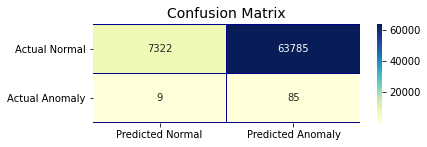

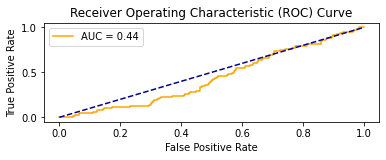

In [ ]:
get_prediction(KNN(contamination= 0.0017, n_neighbors= 500, method= 'median'), train_X_resampled, test_X, train_y_resampled, test_y, 'KNN')


   Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     71107
           1       0.03      0.70      0.06        94

    accuracy                           0.97     71201
   macro avg       0.51      0.84      0.52     71201
weighted avg       1.00      0.97      0.98     71201


   Confusion Matrix: 
 [[68947  2160]
 [   28    66]]

  Matthews Correlation Coefficient 0.14015865766160024

  f1-score 0.056896551724137934


ValueError: ignored

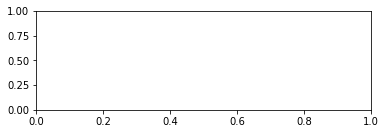

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=1, ntrees=100, penalize_range=False, missing_action = "fail"), train_X_resampled, test_X, train_y_resampled, test_y, 'IForest')

In [ ]:
get_prediction_iso(IsolationForest(sample_size = 256, ndim=2, ntrees=100, ntry=10, penalize_range=True, prob_pick_avg_gain=1, missing_action = "fail"), train_X_resampled, test_X, train_y_resampled, test_y, 'SciForest')